In [5]:
! nvidia-smi

Sun Apr 17 09:54:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
!unzip Ga.zip

Archive:  Ga.zip
   creating: kiemthu/
  inflating: kiemthu/images.jpg      
  inflating: kiemthu/images1.jpg     
  inflating: kiemthu/images2.jpg     
  inflating: kiemthu/images3.jpg     
  inflating: kiemthu/images4.jpg     
  inflating: kiemthu/images5.jpg     
   creating: Gacon/
  inflating: Gacon/gacon (1).jpeg    
  inflating: Gacon/gacon (1).jpg     
  inflating: Gacon/gacon (1).webp    
  inflating: Gacon/gacon (10).jpeg   
  inflating: Gacon/gacon (10).jpg    
  inflating: Gacon/gacon (100).jpg   
  inflating: Gacon/gacon (101).jpg   
  inflating: Gacon/gacon (102).jpg   
  inflating: Gacon/gacon (103).jpg   
  inflating: Gacon/gacon (104).jpg   
  inflating: Gacon/gacon (105).jpg   
  inflating: Gacon/gacon (106).jpg   
  inflating: Gacon/gacon (107).jpg   
  inflating: Gacon/gacon (108).jpg   
  inflating: Gacon/gacon (109).jpg   
  inflating: Gacon/gacon (11).jpeg   
  inflating: Gacon/gacon (11).jpg    
  inflating: Gacon/gacon (110).jpg   
  inflating: Gacon/gacon (111

In [107]:
import glob 
import os
import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16,ResNet50
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [72]:
TEST_SIZE  = 0.4
RANDOM_STATE = 2022
BATCH_SIZE = 64
NO_EPOCHS = 20
NUM_CLASSES = 3
SAMPLE_SIZE = 20000
IMG_SIZE = 224
TRAIN_FOLDER = './chicken/'

In [73]:
def label_pet_image_one_hot_encoder(img):
  pet = img.split('/')[-2]
  if pet == 'Gacon': return [1,0,0]
  elif pet == 'Gatrong': return [0,1,0]
  elif pet == 'Gamai': return [0,0,1]

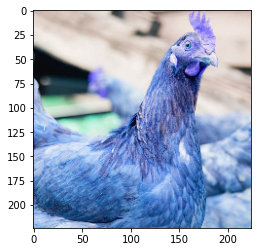

In [74]:
image = cv2.imread('/content/Gamai/Gamai (1).webp')
image = cv2.resize(image,(IMG_SIZE,IMG_SIZE))
plt.imshow(image)

In [75]:
types = ['*.jpg','*.jpeg','*.gif','*.webp'] # the tuple of file types
train_image_list = []
labels_track = [] # contain size of each label
Dir = './Gacon'
for files in types:
  train_image_list.extend(glob.glob(os.path.join(Dir,files)))
labels_track.append(len(train_image_list))

Dir = './Gatrong'
for files in types: 
  train_image_list.extend(glob.glob(os.path.join(Dir,files)))
labels_track.append(len(train_image_list)-np.sum(labels_track))

Dir = './Gamai'
for files in types: 
  train_image_list.extend(glob.glob(os.path.join(Dir,files)))
labels_track.append(len(train_image_list)-np.sum(labels_track))

In [81]:
def process_image(img):
  try:
    img = cv2.imread(img)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
  except Exception as es:
    print(img)
  return np.array(img)

./Gacon/gacon (2).jpg


[1, 0, 0]

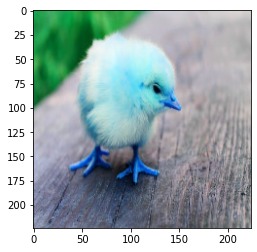

In [82]:
img = process_image(train_image_list[0])
plt.imshow(img)
print(train_image_list[0])
label_pet_image_one_hot_encoder(train_image_list[0])

In [123]:
X = np.zeros((len(train_image_list),IMG_SIZE,IMG_SIZE,3))
Y = []
for i,image in enumerate(tqdm(train_image_list)):
  img = process_image(image)
  #print(img.shape)
  label = label_pet_image_one_hot_encoder(image)
  X[i] = img
  Y.append(label)

 79%|███████▊  | 711/904 [00:01<00:00, 395.36it/s]

None


100%|██████████| 904/904 [00:02<00:00, 439.52it/s]


In [124]:
# X = np.array(X)
Y = np.array(Y)

In [125]:
X.shape

(904, 224, 224, 3)

In [126]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=TEST_SIZE,random_state = RANDOM_STATE)
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train: (542, 224, 224, 3)
X_test: (362, 224, 224, 3)
y_train: (542, 3)
y_test: (362, 3)


In [208]:
model_1 = VGG16(include_top=False,
                input_shape=(IMG_SIZE,IMG_SIZE,3),
                weights = 'imagenet'
                )
model_1.trainable = False
model_2 = ResNet50(include_top=False,
                input_shape=(IMG_SIZE,IMG_SIZE,3),
                weights = 'imagenet'
                )
model_2.trainable = False

In [214]:
model = model_1

In [215]:
# add new classifier layers
gp = tf.keras.layers.GlobalAveragePooling2D()(model.layers[-1].output)
flat = tf.keras.layers.Flatten()(gp)
output = tf.keras.layers.Dense(NUM_CLASSES,activation ='softmax')(flat)
model = tf.keras.Model(inputs = model.inputs,outputs = output)

In [216]:
model.compile(loss = tf.keras.losses.categorical_crossentropy,
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              metrics = ['accuracy'])

In [217]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [218]:
history = model.fit(X_train,y_train,
                    epochs =20,
                    batch_size = 50,
                    verbose = 1,
                    validation_data = (X_test,y_test),
                    validation_split = 0.1
                    )

Epoch 1/20
10/10 [==============================] - 4s 320ms/step - loss: 2.9618 - accuracy: 0.5955 - val_loss: 3.2951 - val_accuracy: 0.6364
Epoch 2/20
10/10 [==============================] - 3s 299ms/step - loss: 1.7435 - accuracy: 0.6632 - val_loss: 1.9263 - val_accuracy: 0.6182
Epoch 3/20
10/10 [==============================] - 3s 300ms/step - loss: 1.0585 - accuracy: 0.7741 - val_loss: 1.3749 - val_accuracy: 0.7455
Epoch 4/20
10/10 [==============================] - 3s 302ms/step - loss: 0.7326 - accuracy: 0.8337 - val_loss: 1.0546 - val_accuracy: 0.8364
Epoch 5/20
10/10 [==============================] - 3s 303ms/step - loss: 0.5913 - accuracy: 0.8563 - val_loss: 0.9354 - val_accuracy: 0.8000
Epoch 6/20
10/10 [==============================] - 3s 305ms/step - loss: 0.4951 - accuracy: 0.8809 - val_loss: 0.8335 - val_accuracy: 0.8000
Epoch 7/20
10/10 [==============================] - 3s 308ms/step - loss: 0.4030 - accuracy: 0.8932 - val_loss: 0.7795 - val_accuracy: 0.8182
Epoch 

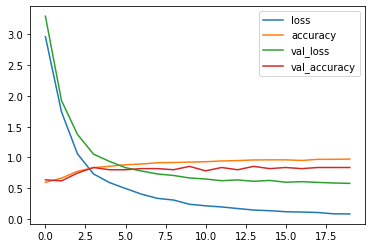

In [219]:
pd.DataFrame(history.history).plot()

In [220]:
y_pred = model.predict(X_test)

In [221]:
cm = confusion_matrix(y_pred= np.argmax(y_pred,axis = 1),y_true = np.argmax(y_test,axis =1))
rp = classification_report(y_pred= np.argmax(y_pred,axis = 1),y_true = np.argmax(y_test,axis =1))
print(cm)
print(rp) 
print(np.sum(cm.diagonal())/len(y_pred))

[[103   4   4]
 [  2 133  20]
 [  5  18  73]]
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       111
           1       0.86      0.86      0.86       155
           2       0.75      0.76      0.76        96

    accuracy                           0.85       362
   macro avg       0.85      0.85      0.85       362
weighted avg       0.85      0.85      0.85       362

0.8535911602209945


In [234]:
model.save('chicken_model')

INFO:tensorflow:Assets written to: chicken_model/assets


In [239]:
!zip -r chicken_model.zip /content/chicken_model 

  adding: content/chicken_model/ (stored 0%)
  adding: content/chicken_model/keras_metadata.pb (deflated 95%)
  adding: content/chicken_model/assets/ (stored 0%)
  adding: content/chicken_model/saved_model.pb (deflated 90%)
  adding: content/chicken_model/variables/ (stored 0%)
  adding: content/chicken_model/variables/variables.index (deflated 66%)
  adding: content/chicken_model/variables/variables.data-00000-of-00001 (deflated 7%)


In [222]:
Dir = './kiemthu'
sample_image_list = []
for files in types:
  sample_image_list.extend(glob.glob(os.path.join(Dir,files)))

In [223]:
X_t = np.zeros((len(sample_image_list),IMG_SIZE,IMG_SIZE,3))
for i,image in enumerate(tqdm(sample_image_list)):
  img = process_image(image)
  X_t[i] = img

100%|██████████| 6/6 [00:00<00:00, 614.49it/s]


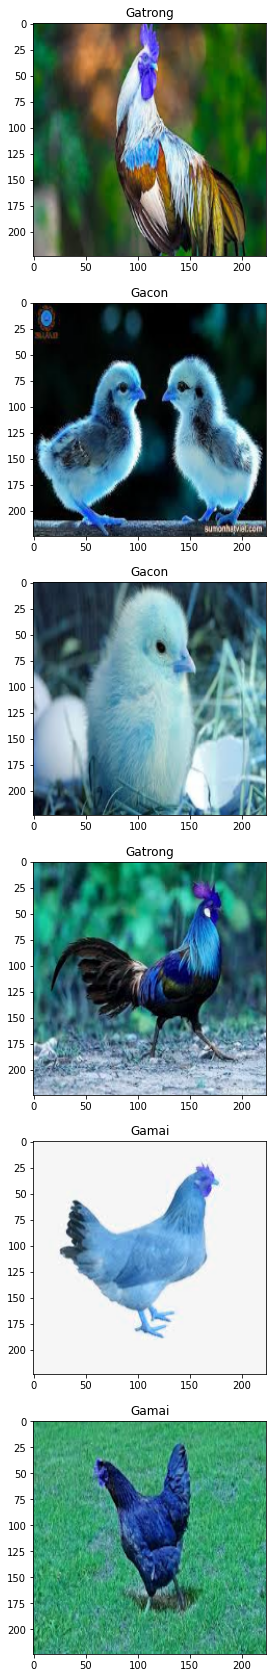

In [225]:
labels = {0:'Gacon',1:'Gatrong',2:'Gamai'}
y_t = np.argmax(model.predict(X_t),axis = 1)
plt.figure(figsize = (30,30))
for i in range(len(y_t)):
  plt.subplot(len(y_t),1,i+1)
  plt.imshow(np.array(X_t[i]).astype('int'))
  plt.title(labels[y_t[i]])

### Grad-CAM

In [1]:
!unzip ./chicken_model.zip

Archive:  ./chicken_model.zip
   creating: content/chicken_model/
  inflating: content/chicken_model/keras_metadata.pb  
   creating: content/chicken_model/assets/
  inflating: content/chicken_model/saved_model.pb  
   creating: content/chicken_model/variables/
  inflating: content/chicken_model/variables/variables.index  
  inflating: content/chicken_model/variables/variables.data-00000-of-00001  


In [2]:
!unzip Ga.zip

Archive:  Ga.zip
   creating: kiemthu/
  inflating: kiemthu/images.jpg      
  inflating: kiemthu/images1.jpg     
  inflating: kiemthu/images2.jpg     
  inflating: kiemthu/images3.jpg     
  inflating: kiemthu/images4.jpg     
  inflating: kiemthu/images5.jpg     
   creating: Gacon/
  inflating: Gacon/gacon (1).jpeg    
  inflating: Gacon/gacon (1).jpg     
  inflating: Gacon/gacon (1).webp    
  inflating: Gacon/gacon (10).jpeg   
  inflating: Gacon/gacon (10).jpg    
  inflating: Gacon/gacon (100).jpg   
  inflating: Gacon/gacon (101).jpg   
  inflating: Gacon/gacon (102).jpg   
  inflating: Gacon/gacon (103).jpg   
  inflating: Gacon/gacon (104).jpg   
  inflating: Gacon/gacon (105).jpg   
  inflating: Gacon/gacon (106).jpg   
  inflating: Gacon/gacon (107).jpg   
  inflating: Gacon/gacon (108).jpg   
  inflating: Gacon/gacon (109).jpg   
  inflating: Gacon/gacon (11).jpeg   
  inflating: Gacon/gacon (11).jpg    
  inflating: Gacon/gacon (110).jpg   
  inflating: Gacon/gacon (111

In [62]:
import os 
import glob
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import scipy as sp

In [4]:
IMG_SIZE = 224

In [5]:
def get_img_array(img_path,size):
  # img is PIL image of size 
  img = tf.keras.preprocessing.image.load_img(img_path,target_size = size)
  # array is float32 numpy array of shape (size,size,3)
  array = tf.keras.preprocessing.image.img_to_array(img)
  # expand dim
  array = np.expand_dims(array,axis = 0)
  return array

In [6]:
img_path = '/content/kiemthu/images.jpg'
img = get_img_array(img_path,(IMG_SIZE,IMG_SIZE))

In [7]:
model = tf.keras.models.load_model('/content/content/chicken_model')

Text(0.5, 1.0, 'Gatrong')

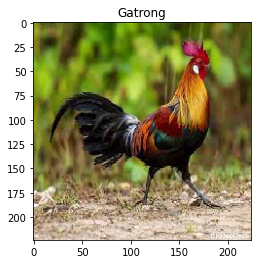

In [10]:
labels = {0:'Gacon',1:'Gatrong',2:'Gamai'}
y_t = np.argmax(model.predict(img))
plt.imshow(np.array(img[0]).astype('int'))
plt.title(labels[y_t])

In [11]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [12]:
model.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_10')>

In [21]:
last_conv_layer = model.get_layer('block5_conv3')
last_conv_layer.output.shape[1:]

TensorShape([14, 14, 512])

In [47]:
cam_model = tf.keras.Model(inputs = model.inputs,
                           outputs = (last_conv_layer.output,model.layers[-1].output))

In [49]:
a = cam_model(img)
a
#plt.imshow(a[0][:,:,0])

(<tf.Tensor: shape=(1, 14, 14, 512), dtype=float32, numpy=
 array([[[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ],
          ...,
          [ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ]],
 
         [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        , ...,  0.        ,
       

In [50]:
b = tf.keras.layers.GlobalAveragePooling2D()(a[0])
b.shape

TensorShape([1, 512])

In [51]:
c = model.layers[-2](b)
c.shape

TensorShape([1, 512])

In [52]:
d = model.layers[-1](c)
print(d)
print(np.argmax(d))
d.shape

tf.Tensor([[5.9725130e-07 9.9999619e-01 3.2309927e-06]], shape=(1, 3), dtype=float32)
1


TensorShape([1, 3])

In [53]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

(512, 3)

In [54]:
features,output = cam_model.predict(img)

In [57]:
features_one_img = features[0,:,:,:]
features_one_img.shape

(14, 14, 512)

In [60]:
height_zoom = img.shape[1]/features_one_img.shape[0]
width_zoom = img.shape[2]/features_one_img.shape[1]
print(f"height_zoom: {height_zoom}")
print(f"width_zoom: {width_zoom}")

height_zoom: 16.0
width_zoom: 16.0


In [65]:
cam_features = sp.ndimage.zoom(features_one_img,(height_zoom,width_zoom,1))
cam_features.shape

(224, 224, 512)

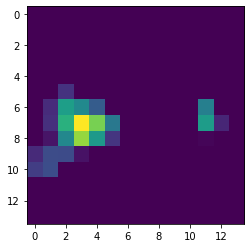

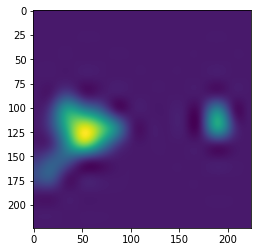

In [68]:
plt.imshow(features_one_img[:,:,0])
plt.figure()
plt.imshow(cam_features[:,:,0])

pred_label: 1
(224, 224)


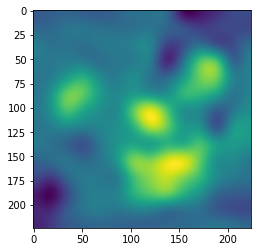

In [77]:
pred_label = np.argmax(output)
print(f"pred_label: {pred_label}")
cam_output = cam_features @ gap_weights[:,pred_label] 
print(cam_output.shape)
plt.imshow(cam_output)

Text(0.5, 1.0, 'Gatrong')

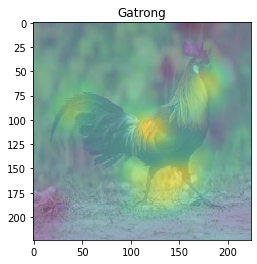

In [78]:
labels = {0:'Gacon',1:'Gatrong',2:'Gamai'}
y_t = np.argmax(model.predict(img))
plt.imshow(np.array(img[0]).astype('int'),alpha  = 0.5)
plt.imshow(cam_output,alpha = 0.5)
plt.title(labels[y_t])

### References

https://viblo.asia/p/tim-hieu-ve-class-activation-maping-tai-sao-cac-mang-than-kinh-lai-dua-ra-quyet-dinh-nhu-vay-63vKjDXkl2R

https://github.com/wiqaaas/youtube/blob/master/Deep_Learning_Using_Tensorflow/Imbalanced_X_Ray_Classification/Imbalanced%20X-ray%20Classification.ipynb

https://github.com/ismailuddin/gradcam-tensorflow-2/blob/master/notebooks/GradCam.ipynb

https://www.youtube.com/watch?v=RNnKtNrsrmg

https://github.com/jacobgil/pytorch-grad-cam

https://fairyonice.github.io/Grad-CAM-with-keras-vis.html

https://github.com/jacobgil/keras-grad-cam

https://keras.io/examples/vision/grad_cam/

https://pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/

https://github.com/samson6460/tf_keras_gradcamplusplus

https://dlhr.de/8

https://jsideas.net/grad_cam/